In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from functions import *
%matplotlib inline

Per trovare i materiali che compongono i cluster scegliamo di **non eseguire un fit su ogni spettro all'interno di un determinato cluster**, ma **procediamo mediando su tutti gli spettri presenti nei singoli cluster e fittiamo sul risultato della media.**

Importiamo cosi i centroidi dei vari cluster, che vengono restituiti in automatico dall'algoritmo k-means utilizzato per la clusterizzazione.

## Import dei dati

In [3]:
#import dei pesi dei cluster
labels=np.loadtxt("../data/processed/CLUSTERING_labels.txt")

In [4]:
# import dei centroidi
data = pd.read_csv("../data/processed/CLUSTERING_data_centres.csv")
data.drop(labels='Unnamed: 0',inplace=True,axis=1)

In [5]:
pure_material_names,pure_materials = import_pure_spectra('../data/raw/Database Raman/BANK_LIST.dat','../data/raw/Database Raman/')

## Interpolazione

**Le frequenze di campionamento degli spettri puri sono diverse tra loro e diverse da quelle utilizzate per il campionamento degli spettri sperimentali.** Per poter eseguire un fit dobbiamo per prima cosa interpolare i dati degli spettri puri con quelli degli spettri sperimentali. Dopo l'interpolazione le frequenze degli spettri puri saranno le stesse delle frequenze degli spettri sperimentlai.

In [6]:
pure_materials_interpoled=pd.DataFrame(data.wn.copy())
for temp in pure_material_names:
    pure_materials_interpoled=pure_materials_interpoled.join(pd.DataFrame(np.interp(data.wn, pure_materials[temp+'_wn'] ,pure_materials[temp+'_I']),columns=[temp]))

Dopo aver interpolato i dati normalizziamo gli spettri puri.

In [7]:
#Normalizzazione
for i in pure_material_names:
    pure_materials_interpoled[i]=pure_materials_interpoled[i]/np.trapz(abs(pure_materials_interpoled[i].dropna()), x=pure_materials_interpoled.wn)

## Fit

Per fittare gli spettri puri ai dati ragioniamo in questo modo:

- possiamo vedere lo spettro incognito del centroide $C$ come una combinazione lineare con coefficienti non negativi di tutti gli spettri puri $P_{i}$.

- Nel nostro modello gli spettri puri $P_{i} \in \mathbb{R}^n$ dove $n$ e' la dimesnionalita' del vettore delle intensita' dei vari spettri.
 
- $C = \sum \alpha_{i}P_{i} + P_{0} $ dove $P_{0}$ e' un parametro costante.

Fortunatamente nell'ultimo aggiornamento di SikitLearn (rilasciato proprio nel periodo in cui abbiamo lavorato al progetto) e' stato introdotto il parametro "positive" in LinearRegression, che permette di considerare solo coefficienti non negativi. Questo è stato fondamentale dato che in ogni caso sarebbe stato necessario implementarlo, altrimenti il FIT utilzzava combinazioni di coeficienti positivi e negativi per utilizzando tutti gli spettri in modo da fittare il rumore.

In [8]:
ols=LinearRegression(positive=True) #definisco il regressore

Per ogni cluster facciamo quindi una regressione lineare estrapolando i coefficienti e l'intercetta.

In [9]:
N_cluster=len(data.columns)-1
coeff=[]
intercept=[]
for i in range(N_cluster):
    ols.fit(pure_materials_interpoled[pure_material_names], data[str(i)]) #ottimizziamo il modello (lineare) su i dati di training
    coeff.append(ols.coef_)
    intercept.append(ols.intercept_)

### Plot dei vari centroidi dei cluster e del rispettivo fit

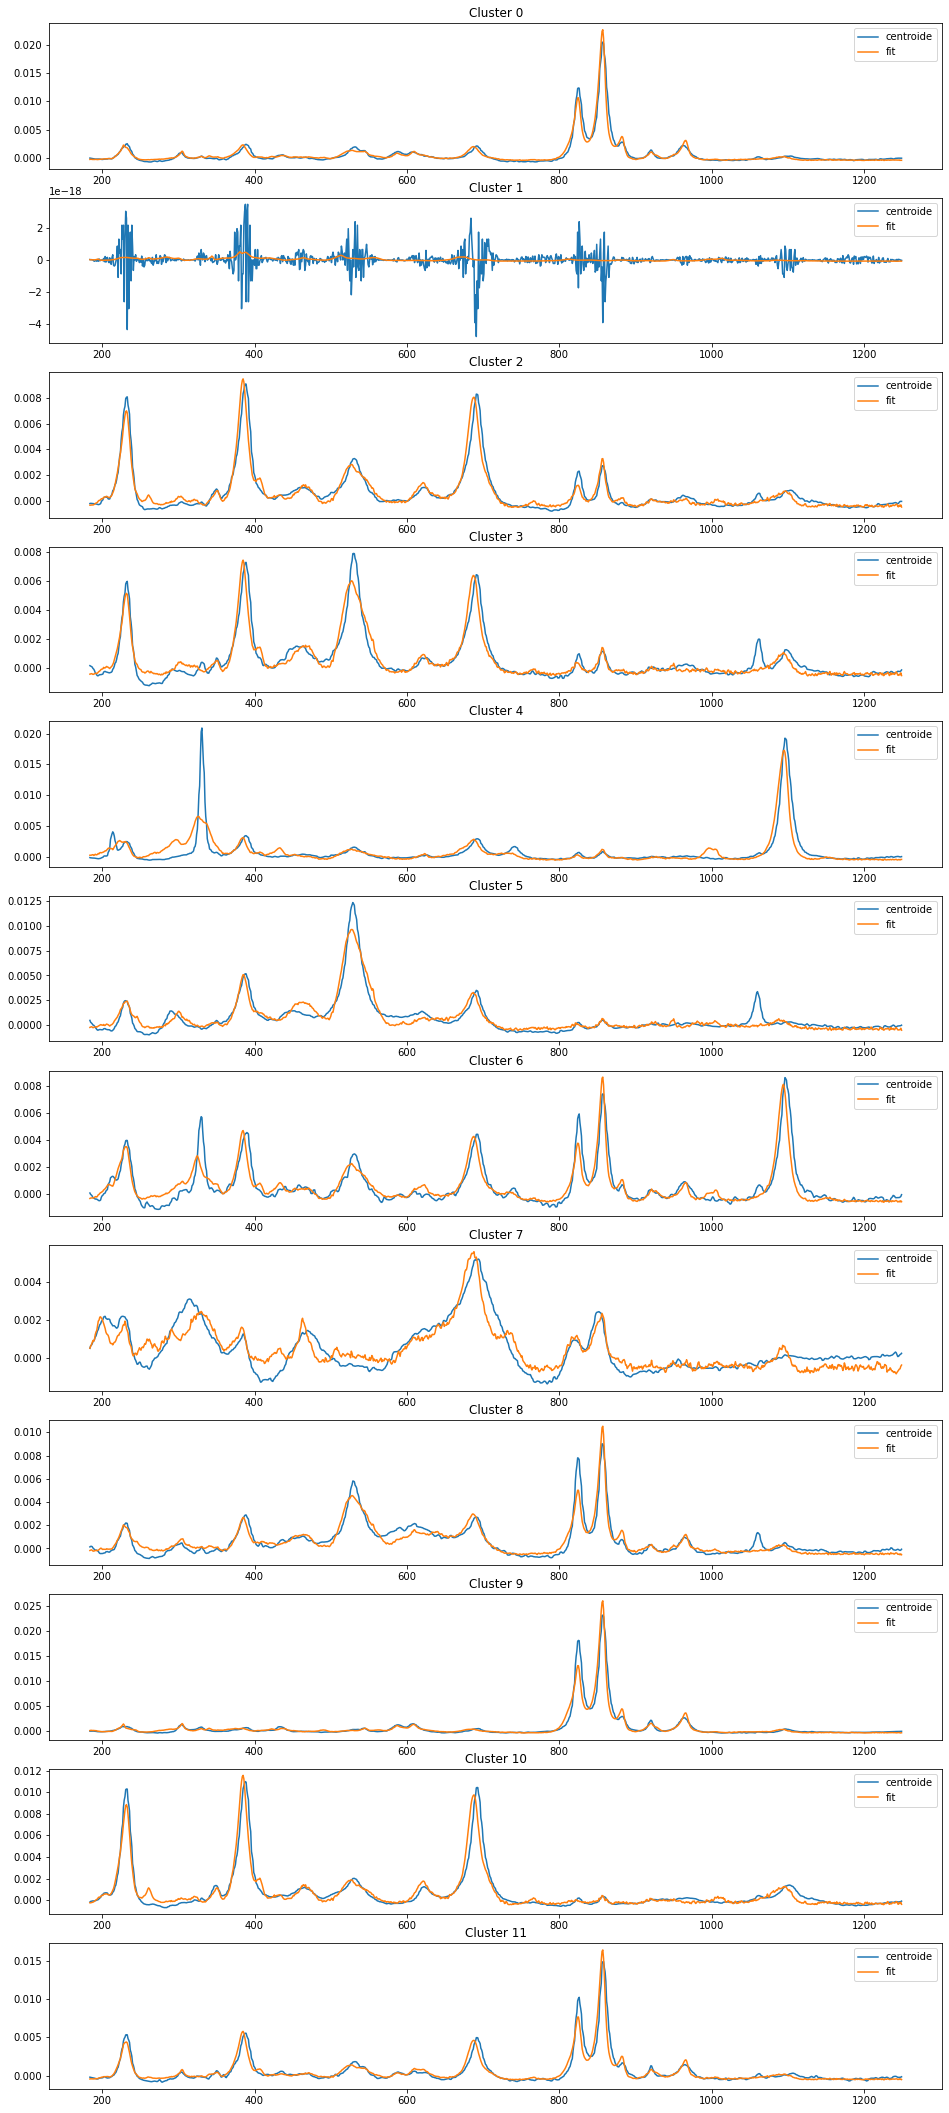

In [10]:
fig, axs = plt.subplots(nrows = N_cluster,figsize = (16,38))
for i in enumerate(range(N_cluster)):
    axs[i[0]].plot(data.wn,data[str(i[0])])
    axs[i[0]].plot(pure_materials_interpoled.wn,intercept[i[0]]+np.sum(pure_materials_interpoled[pure_material_names] * coeff[i[0]] ,axis=1))
    axs[i[0]].set_title('Cluster ' + str(i[0]))
    axs[i[0]].legend(['centroide','fit'], loc='upper right')

## Determinazione dell'abbondanza del materiale

Tenendo conto del numero di spettri presenti in ogni cluster, determiniamo il materiale piu' abbondande nel campione utilizzando i coefficienti dei fit. **Otteniamo così il risultato finale: le abbondanze nel campione**.

In [20]:
#elimino il cluster a 0 (se presente) e normalizzare i coefficienti per ogni cluster
for temp in np.unique(labels):
    if max(data[str(int(temp))])>1e-10:
        coeff[int(temp)]=coeff[int(temp)]/sum(coeff[int(temp)])
    else:
        print(f'Identificato lo spettro piatto, non utilizzato il cluster {int(temp)}')
        coeff[int(temp)]=np.zeros(len(coeff[int(temp)]))

#numero di spettri per cluster in ordine
weights=[np.count_nonzero(labels==i) for i in range(len(data.columns)-1)]

#moltiplico i coeficienti del cluster i-esimo per questo numero
abb_notnormalized=[coeff[i]*weights[i] for i in range(len(data.columns)-1)]

#e infine ho la media pesata dei coeficienti
abb=sum(abb_notnormalized)/(sum(abb_notnormalized).sum())

#Creo un Pandas dataframe con nomi e abbondanze
abb_table=pd.DataFrame({'names':pure_material_names,'abbundances':abb})

#riordino in base alla concenrazione
abb_table.sort_values('abbundances',ascending=False,inplace=True, ignore_index=True)

abb_table[abb_table['abbundances']>0.01]

Identificato lo spettro piatto, non utilizzato il cluster 1


,names,abbundances
0,Chrysotile,0.401974
1,Forsterite,0.137696
2,Dwornikite,0.136892
3,Jarosite,0.033396
4,Magnesiochromite,0.027345
5,Spinel,0.024852
6,Arsenopyrite,0.019172
7,Fayalite,0.017221
8,Magnesite,0.016771
9,Goethite,0.015422


In [21]:
abb_table.to_csv("../data/processed/abb_table.csv")

[array([0.        , 0.00898991, 0.        , 0.00184671, 0.0085143 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.147209  , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.07841711,
        0.        , 0.01762783, 0.06202325, 0.        , 0.5661129 ,
        0.        , 0.00141434, 0.        , 0.        , 0.        ,
        0.00114131, 0.0029368 , 0.0097951 , 0.        , 0.00582745,
        0.00250787, 0.01344803, 0.00535358, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00170653, 0.        , 0.01170869,
        0.01814481, 0.        , 0.        , 0.        , 0.0077422 ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.02753228]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.